In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("Online Retail.xlsx")

# Data Preprocessing

In [3]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df = df.drop(["Description"],axis=1)

In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

<AxesSubplot:>

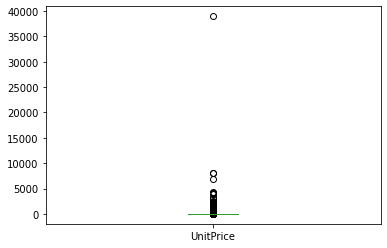

In [8]:
df["UnitPrice"].plot(kind="box")

In [9]:
df_sorted = df[df["Quantity"]!=-1].sort_values(by=["UnitPrice"], ascending=False)

In [10]:
len(df_sorted[df_sorted["UnitPrice"]>1000])

22

In [11]:
df = df_sorted[df_sorted["UnitPrice"]<1000][df_sorted["Quantity"]>0][df["UnitPrice"]>0]

C:\Users\nehue\AppData\Local\Temp\ipykernel_12816\41533685.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_sorted[df_sorted["UnitPrice"]<1000][df_sorted["Quantity"]>0][df["UnitPrice"]>0]


In [12]:
import re

In [13]:
stc = df["StockCode"].unique()

stock_with_words = [stockcode for stockcode in stc if type(stockcode)!=int]
stock_with_words = [sc for sc in stock_with_words if not any(char.isdigit() for char in sc)]

In [14]:
stock_with_words

['DOT', 'M', 'POST', 'BANK CHARGES', 'PADS']

In [15]:
for word in stock_with_words:

    df = df[df["StockCode"]!=word]

<AxesSubplot:>

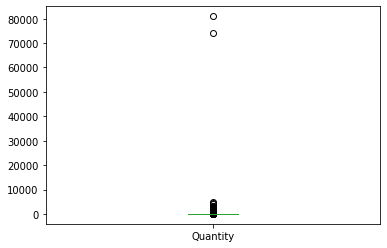

In [16]:
df["Quantity"].plot(kind="box")

In [17]:
df[df["Quantity"]>10000]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
61619,541431,23166,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom


In [18]:
df = df[df["Quantity"]<3000]


# Feature selection and engineering

- Create more features (based on each customer): average_purchase_quantity, average_purchase_expense, Purchase_frequency, time_as_buyer, lifetime_expenses, unique_items_bought

- Encode categorical features: Country



In [19]:
# average_purchase_quantity

df['average_purchase_quantity'] = df.groupby('CustomerID')['UnitPrice'].transform('mean')

In [20]:
# average_purchase_expense

df['average_purchase_expense'] = df.groupby('CustomerID')['Quantity'].transform('mean')

In [21]:
# Purchase_frequency

purchase_dates = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max', "count"])

purchase_dates['Purchase_frequency'] = (purchase_dates['max'] - purchase_dates['min']).dt.days / purchase_dates["count"]

df = pd.merge(df, purchase_dates['Purchase_frequency'], on='CustomerID')

In [22]:
# time_as_buyer

purchase_dates = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])

purchase_dates['time_as_buyer'] = (purchase_dates['max'] - purchase_dates['min']).dt.days

df = pd.merge(df, purchase_dates['time_as_buyer'], on='CustomerID')

In [23]:
# lifetime_expenses

df["lifetime_expenses"] = df.groupby('CustomerID')['UnitPrice'].transform('sum')

In [24]:
# unique_items_bought

unique = df.groupby('CustomerID')['StockCode'].nunique()

unique_df = unique.to_frame()

df = pd.merge(df, unique_df, on='CustomerID')

df["unique_items_bought"] = df["StockCode_y"]

df = df.drop(columns="StockCode_y")
df = df.drop(columns="StockCode_x")

In [25]:
df = pd.get_dummies(df, columns=['Country'])

In [26]:
df.columns

Index(['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID',
       'average_purchase_quantity', 'average_purchase_expense',
       'Purchase_frequency', 'time_as_buyer', 'lifetime_expenses',
       'unique_items_bought', 'Country_Australia', 'Country_Austria',
       'Country_Bahrain', 'Country_Belgium', 'Country_Brazil',
       'Country_Canada', 'Country_Channel Islands', 'Country_Cyprus',
       'Country_Czech Republic', 'Country_Denmark', 'Country_EIRE',
       'Country_European Community', 'Country_Finland', 'Country_France',
       'Country_Germany', 'Country_Greece', 'Country_Iceland',
       'Country_Israel', 'Country_Italy', 'Country_Japan', 'Country_Lebanon',
       'Country_Lithuania', 'Country_Malta', 'Country_Netherlands',
       'Country_Norway', 'Country_Poland', 'Country_Portugal', 'Country_RSA',
       'Country_Saudi Arabia', 'Country_Singapore', 'Country_Spain',
       'Country_Sweden', 'Country_Switzerland', 'Country_USA',
       'Country_United Arab Emi

In [27]:
# Converting to a customer based dataframe and leaving out unecessary features:

df.drop(columns=["InvoiceNo", "Quantity", "InvoiceDate","UnitPrice"], inplace=True)

df = df.groupby('CustomerID').apply(pd.DataFrame).reset_index().drop_duplicates()

df.drop(columns=["CustomerID"], inplace=True)

C:\Users\nehue\AppData\Local\Temp\ipykernel_12816\475855175.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby('CustomerID').apply(pd.DataFrame).reset_index().drop_duplicates()


In [37]:
df.drop(columns=["index"], inplace=True)
df.drop_duplicates(inplace=True)

## Exploratory Data Analysis (EDA)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4327 entries, 0 to 396460
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   average_purchase_quantity     4327 non-null   float64
 1   average_purchase_expense      4327 non-null   float64
 2   Purchase_frequency            4327 non-null   float64
 3   time_as_buyer                 4327 non-null   int64  
 4   lifetime_expenses             4327 non-null   float64
 5   unique_items_bought           4327 non-null   int64  
 6   Country_Australia             4327 non-null   uint8  
 7   Country_Austria               4327 non-null   uint8  
 8   Country_Bahrain               4327 non-null   uint8  
 9   Country_Belgium               4327 non-null   uint8  
 10  Country_Brazil                4327 non-null   uint8  
 11  Country_Canada                4327 non-null   uint8  
 12  Country_Channel Islands       4327 non-null   uint8  
 13  C

In [39]:
df.describe()

,average_purchase_quantity,average_purchase_expense,Purchase_frequency,time_as_buyer,lifetime_expenses,unique_items_bought,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
count,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,...,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000,4327.000000
mean,3.436285,20.109094,2.803768,130.927201,264.903970,61.699099,0.002080,0.002542,0.000462,0.005778,...,0.000231,0.000231,0.000231,0.006933,0.001849,0.004853,0.000924,0.000462,0.901548,0.000924
std,8.718643,76.592182,6.925594,132.147536,704.065134,85.346700,0.045564,0.050362,0.021497,0.075800,...,0.015202,0.015202,0.015202,0.082986,0.042964,0.069504,0.030394,0.021497,0.297959,0.030394
min,0.143333,1.000000,0.000000,0.000000,0.170000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.158219,6.031019,0.000000,0.000000,49.635000,16.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.828276,10.000000,1.065282,94.000000,122.750000,35.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.707700,14.678669,2.896602,252.000000,282.795000,78.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,434.650000,2140.000000,154.500000,373.000000,22811.380000,1786.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Analyzing Distributions:

<AxesSubplot:>

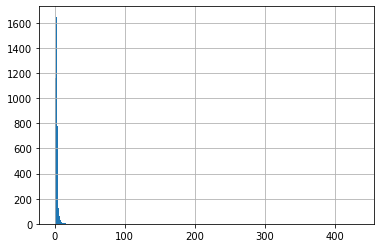

In [45]:
df['average_purchase_quantity'].hist(bins=400)

<AxesSubplot:>

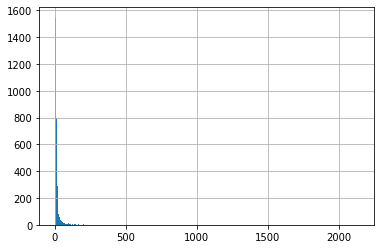

In [46]:
df['average_purchase_expense'].hist(bins=400)


<AxesSubplot:>

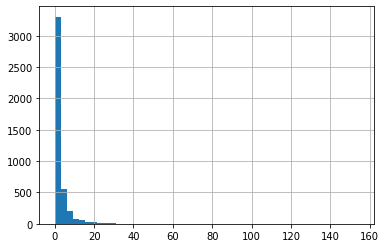

In [48]:
df['Purchase_frequency'].hist(bins=50)


<AxesSubplot:>

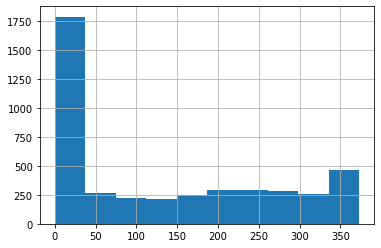

In [50]:
df['time_as_buyer'].hist(bins=10)


<AxesSubplot:>

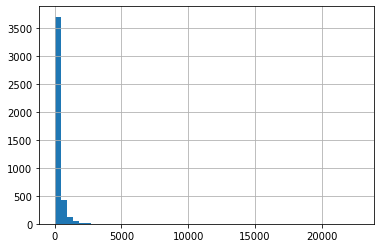

In [54]:
df['lifetime_expenses'].hist(bins=50)

<AxesSubplot:>

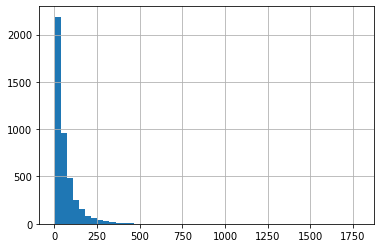

In [55]:
df['unique_items_bought'].hist(bins=50)

In [57]:
# Using boxplots to detect outliers:

def plot_boxplots(df):
    numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

    num_features = len(numerical_features)
    fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 5))

    for i, feature in enumerate(numerical_features):

        df[feature].plot(kind='box', ax=axes[i], color='blue')
        axes[i].set_title(feature)

    plt.tight_layout()
    plt.show()

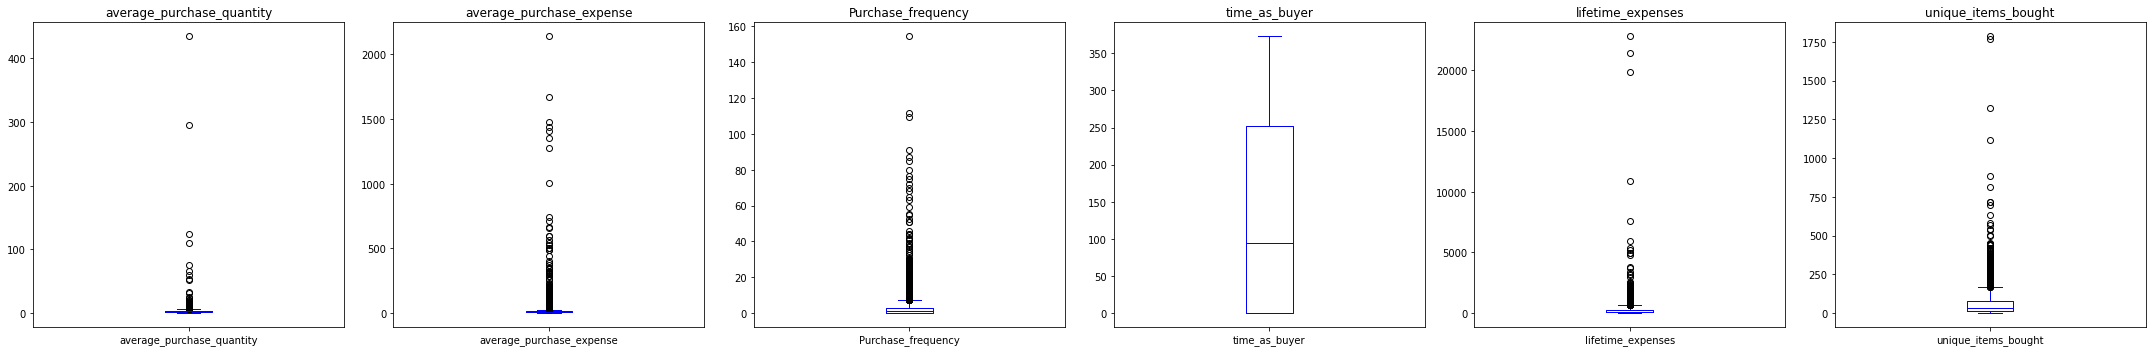

In [58]:
plot_boxplots(df)

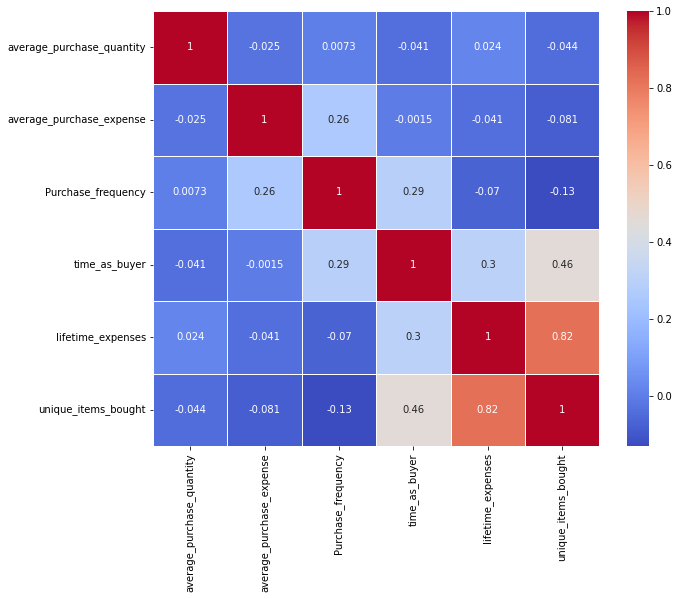

In [60]:
correlation_matrix = df[["average_purchase_quantity", "average_purchase_expense","Purchase_frequency","time_as_buyer",	"lifetime_expenses","unique_items_bought"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


"The time as a buyer is proportionally related to the unique number of items that customer has bought and the more unique items they've bought the higher their life time expenses turn out to be"

In [65]:
import itertools

def plot_scatter_plots(df):
    numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

    feature_combinations = list(itertools.combinations(numerical_features, 2))

    num_combinations = len(feature_combinations)
    fig, axes = plt.subplots(1, num_combinations, figsize=(5 * num_combinations, 5))

    for i, (x_feature, y_feature) in enumerate(feature_combinations):
        df.plot.scatter(x=x_feature, y=y_feature, ax=axes[i], color='skyblue')
        axes[i].set_title(f"{x_feature} vs {y_feature}")
    
    plt.tight_layout()
    plt.show()

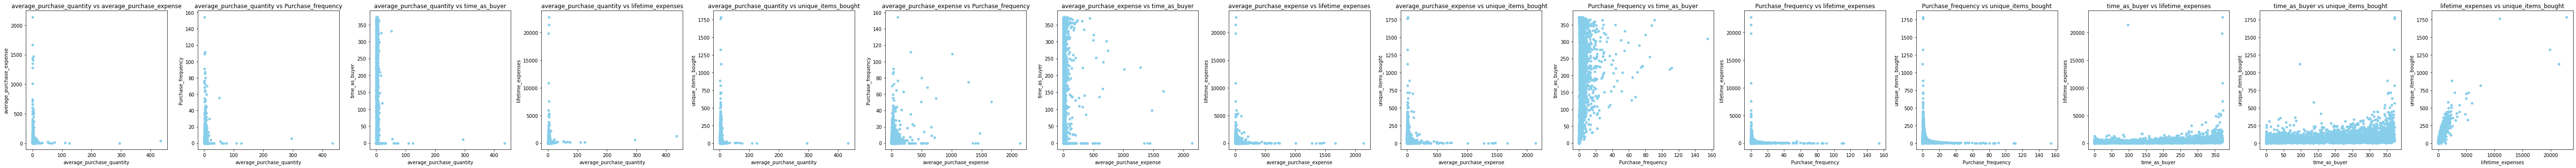

In [66]:
plot_scatter_plots(df)

# Feature scaling

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)